In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import requests

import openai
from tenacity import retry, stop_after_attempt, wait_random_exponential

from nltk.translate.bleu_score import sentence_bleu
from nltk.tokenize import word_tokenize

import warnings
warnings.filterwarnings("ignore")

from transformers import BertTokenizer, BertModel
from sklearn.metrics.pairwise import cosine_similarity
import torch.nn.functional as F
import torch

In [4]:
# Read CSV file
df = pd.read_csv("Data/squad.csv")
df.head(3)

,title,context,question,answers,reference,context_arm_GT,context_arm_BT_GT,question_arm_GT,question_arm_BT_GT,reference_arm_GT,reference_arm_BT_GT
0,Institute_of_technology,The world's first institution of technology or...,What year was the Banská Akadémia founded?,"{'text': array(['1735'], dtype=object), 'answe...",1735,Աշխարհի առաջին տեխնոլոգիական կամ բարձրագույն տ...,The world's first university of technological ...,Ո՞ր թվականին է հիմնադրվել Բանսկայի Ակադեմիան:,In what year was Banska Academy founded?,1735 թ,1735
1,Film_speed,The standard specifies how speed ratings shoul...,What is another speed that can also be reporte...,"{'text': array(['SOS-based speed'], dtype=obje...",SOS-based speed,"Ստանդարտը սահմանում է, թե ինչպես պետք է արագու...",The standard specifies how speed ratings shoul...,"Ո՞րն է մեկ այլ արագություն, որը կարող է նաև հա...",What is another speed that can also be reporte...,SOS-ի վրա հիմնված արագություն,SOS based speed
2,Sumer,The most impressive and famous of Sumerian bui...,Where were the use of advanced materials and t...,{'text': array(['Sumerian temples and palaces'...,Sumerian temples and palaces,Շումերական շինություններից ամենատպավորիչն ու ն...,The most impressive and notable of the Sumeria...,Որտե՞ղ էին Շումերում ցուցադրված առաջադեմ նյութ...,Where was the use of advanced materials and te...,Շումերական տաճարներ և պալատներ,Sumerian temples and palaces


In [3]:
# Read the API key from the file
with open('api_key.txt', 'r') as file:
    api_key = file.read().strip()

# Set the API key in the OpenAI library
openai.api_key = api_key

# Define the model to use
GPT_MODEL = "gpt-3.5-turbo-0613"

In [5]:
@retry(wait=wait_random_exponential(multiplier=1, max=40), stop=stop_after_attempt(3))
def chat_completion_request(messages, tools=None, tool_choice=None, model = GPT_MODEL):
    """
    Sends request to the OpenAI API to generate chat completions based on the provided messages.

    Parameters:
    - messages (list): A list of message dictionaries to be sent to the chat completion model.
    - tools (list, optional): A list of tools that can be utilized for generating completions.
    - tool_choice (str, optional): A specific tool choice to influence the completion generation.
    - model (str): The model to be used for generating completions.

    Returns:
    - dict: The JSON response from the API containing the completion if the request is successful.

    Raises:
    - Exception: If the request fails after the maximum number of retry attempts, it raises and
      returns the exception, and prints an error message to the console.
    """
    headers = {
        "Content-Type": "application/json",
        "Authorization": "Bearer " + openai.api_key,
    }
    json_data = {"model": model, "messages": messages}

    if tools is not None:
        json_data.update({"tools": tools})
    if tool_choice is not None:
        json_data.update({"tool_choice": tool_choice})
        
    try:
        response = requests.post(
            "https://api.openai.com/v1/chat/completions",
            headers=headers,
            json=json_data,
        )
        return response.json() 
    except Exception as e:
        print("Unable to generate ChatCompletion response")
        print(f"Exception: {e}")
        return e

# Translationions

## Google Translate

In [8]:
def calculate_bleu(reference_text, candidate_text):
    """
    Calculate the BLEU score for a candidate text given a reference text.

    Parameters:
    - reference_text (str): The reference text against which the candidate is evaluated.
    - candidate_text (str): The candidate text that is being evaluated.

    Returns:
    - float: The BLEU score for the candidate text.
    """
    reference = word_tokenize(reference_text.lower())
    candidate = word_tokenize(candidate_text.lower())
    return sentence_bleu([reference], candidate)

In [29]:
# Calculating BLEU score for the given columns
df['BLEU_score_GT_context'] = df.apply(lambda row: calculate_bleu(row['context'], row['context_arm_BT_GT']), axis=1)
df['BLEU_score_GT_question'] = df.apply(lambda row: calculate_bleu(row['question'], row['question_arm_BT_GT']), axis=1)
df['BLEU_score_GT_reference'] = df.apply(lambda row: calculate_bleu(row['reference'], row['reference_arm_BT_GT']), axis=1)

In [30]:
# Calculate summary statistics for each column
stats_context_GT = df['BLEU_score_GT_context'].describe()
stats_question_GT = df['BLEU_score_GT_question'].describe()

stats_df_GT = pd.DataFrame({
    'Context': stats_context_GT.round(2),
    'Question': stats_question_GT.round(2)
})

print(stats_df_GT)

       Context  Question
count    50.00     50.00
mean      0.61      0.55
std       0.09      0.30
min       0.34      0.00
25%       0.54      0.40
50%       0.61      0.58
75%       0.66      0.73
max       0.83      1.00


## GPT Translation

In [17]:
def translate(source_text, target_language):
    """
    Constructs a request for translation from source text into target language.

    Parameters:
    - source_text (str): The text to be translated.
    - target_language (str): The language into which the text should be translated.

    Returns:
    - str: The translated text as generated by the chat completion system.
    """
    system_message = "You are a helpful assistant."
    user_message = (
        f"Translate the following text into {target_language}.\n"
        "Keep the structure of the original text and preserve things like code and names.\n"
        "Please ensure that your response contains only the translated text.\n"
        "The translation must convey the same meaning as the original and be natural for native speakers with correct grammar and proper word choices.\n"
        "Your translation must also use exact terminology to provide accurate information even for the experts in the related fields.\n"
        f"Original: {source_text}\n"
        f"Translation into {target_language}:"
    )
    
    messages = []
    messages.append({"role": "system", "content": system_message})
    messages.append({"role": "assistant", "content": user_message})
    
    chat_response = chat_completion_request(messages)
    assistant_message = chat_response["choices"][0]["message"]["content"] 
    return assistant_message

In [18]:
def translate_df_column(df, column_name, target_language, new_column_name):
    """
    Translates text in a specified column of a DataFrame to a given target language.

    This function iterates through the DataFrame, translates each text in the specified column,
    and stores the translations in a new column. Finally, it saves the updated DataFrame
    to a CSV file.

    Parameters:
    - df (pandas.DataFrame): The DataFrame containing text to translate.
    - column_name (str): Name of the column with texts to translate.
    - target_language (str): The language into which texts should be translated.
    - new_column_name (str): The name for the new column to store translated texts.
    """
    for index, row in df.iterrows():
        source_text = row[column_name]
        translation = translate(source_text, target_language)
        df.at[index, new_column_name] = translation

    df.to_csv('Data/squad.csv', index=False)

In [19]:
translate_df_column(df, 'context', 'Armenian', 'context_arm_gpt')
translate_df_column(df, 'question', 'Armenian', 'question_arm_gpt')

In [21]:
translate_df_column(df, 'context_arm_gpt', 'English', 'context_arm_BT_gpt')
translate_df_column(df, 'question_arm_gpt', 'English', 'question_arm_BT_gpt')

In [31]:
# BLEU score for GPT translation
df['BLEU_score_gpt_context'] = df.apply(lambda row: calculate_bleu(row['context'], row['context_arm_BT_gpt']), axis=1)
df['BLEU_score_gpt_question'] = df.apply(lambda row: calculate_bleu(row['question'], row['question_arm_BT_gpt']), axis=1)

In [32]:
# Calculate summary statistics for each column
stats_context_gpt = df['BLEU_score_gpt_context'].describe()
stats_question_gpt = df['BLEU_score_gpt_question'].describe()

stats_df_gpt = pd.DataFrame({
    'Context': stats_context_gpt.round(2),
    'Question': stats_question_gpt.round(2)
})

print(stats_df_gpt)

       Context  Question
count    50.00     50.00
mean      0.09      0.06
std       0.08      0.18
min       0.00      0.00
25%       0.03      0.00
50%       0.08      0.00
75%       0.15      0.00
max       0.33      1.00


In [8]:
# Prepare DataFrame for plotting
data_for_plotting = pd.DataFrame({
    'GT Context': df['BLEU_score_GT_context'],
    'GT Question': df['BLEU_score_GT_question'],
    'GPT Context': df['BLEU_score_gpt_context'],
    'GPT Question': df['BLEU_score_gpt_question']
})

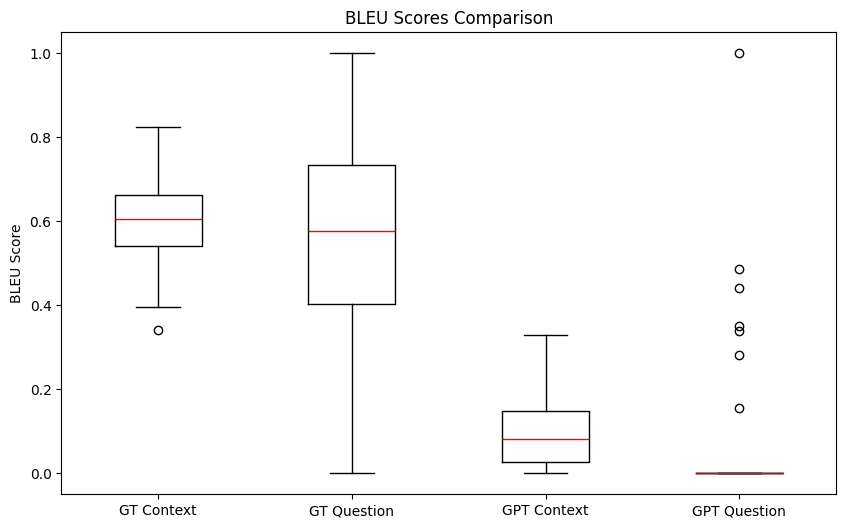

In [9]:
# Boxplot of BLEU Scores Comparison
plt.figure(figsize=(10, 6))
plt.boxplot(data_for_plotting.values, labels=data_for_plotting.columns,
            medianprops=dict(color='red'))
plt.title('BLEU Scores Comparison')
plt.ylabel('BLEU Score')
plt.savefig('bleu_score_statistics.png')
plt.show()

# Zero-Shot Prompting

In [60]:
def zero_shot_question(passage, question, language="English"):
    """
    Request an answer to a specified question based on a given text passage in a specified language.

    Parameters:
    - passage (str): The text passage from which the answer should be extracted.
    - question (str): The question for which an answer is sought.
    - language (str, optional): The language in which the question and passage are written. Defaults to "English".

    Returns:
    - str: The extracted answer if available; otherwise, an error message.

    Raises:
    - Exception: Outputs an error message to the console if the response structure is unexpected.
    """
    system_message = f"Answer the question from the given passage in {language}. Your answer should be directly extracted from the passage, and it should be a single entity, name, or number, not a sentence."
    messages = [
        {"role": "system", "content": system_message},
        {"role": "user", "content": passage},
        {"role": "assistant", "content": question}
    ]
    
    try:
        chat_response = chat_completion_request(messages)
        if 'choices' in chat_response and len(chat_response['choices']) > 0:
            assistant_message = chat_response['choices'][0].get('message', {}).get('content', '')
            return assistant_message
        else:
            raise ValueError("Error: 'choices' not found or empty in the response.")
    except Exception as e:
        print(f"Error processing the request: {e}")
        print("Passage:", passage)
        print("Question:", question)
        return "Error in processing the response"


In [61]:
def apply_zero_shot_to_df(df, context_col, question_col, response_col, language="English"):
    """
    Applies zero-shot question answering to specified context and question columns of a DataFrame,
    and stores the responses in a new column.

    Parameters:
    - df (pandas.DataFrame): The DataFrame containing the data.
    - context_col (str): Name of the column containing the context.
    - question_col (str): Name of the column containing the questions.
    - response_col (str): Name of the column where the responses will be stored.
    - language (str, optional): The language in which the questions and contexts are provided. Defaults to "English".
    """
    for index, row in df.iterrows():
        response = zero_shot_question(row[context_col], row[question_col], language)
        df.at[index, response_col] = response

    # Save the DataFrame after updating
    df.to_csv('Data/squad.csv', index=False)

In [62]:
apply_zero_shot_to_df(df, 'context', 'question', 'response_en_ZS')
apply_zero_shot_to_df(df, 'context_arm_GT', 'question_arm_GT', 'response_arm_ZS', language='Armenian')

# One-Shot Prompting

In [64]:
def one_shot_question(passage, question, example, language="English"):
    """
    Executes a one-shot learning-based question answering with an example provided.

    Parameters:
    - passage (str): The text from which the answer should be derived.
    - question (str): The question that needs answering.
    - example (dict): An example containing a passage, question, and answer to guide the model.
    - language (str): The language in which the question and passage are written. Defaults to "English".
    
    Returns:
    - str: The extracted answer if available; otherwise, an error message.
    """
    system_message = f"Answer the question from the given passage in {language}. Your answer should be directly extracted from the passage, and it should be a single entity, name, or number, not a sentence."
    messages = [
        {"role": "system", "content": system_message},
        {"role": "user", "content": example["passage"]},
        {"role": "assistant", "content": example["question"]},
        {"role": "assistant", "content": example["answer"]},
        {"role": "user", "content": passage},
        {"role": "assistant", "content": question}
    ]
    chat_response = chat_completion_request(messages)

    if 'choices' in chat_response and len(chat_response['choices']) > 0:
        return chat_response['choices'][0].get('message', {}).get('content', '')
    else:
        print("Error: 'choices' not found or empty in the response.")
        print("Passage:", passage)
        print("Question:", question)
        return "Error in processing the response"

In [65]:
def apply_one_shot_to_df(df, context_col, question_col, response_col, example, language="English"):
    """
    Applies one-shot question answering to specified context and question columns of a DataFrame,
    using a provided example, and stores the responses in a new column.

    Parameters:
    - df (pandas.DataFrame): The DataFrame containing the data.
    - context_col (str): Name of the column containing the context.
    - question_col (str): Name of the column containing the questions.
    - response_col (str): Name of the column where the responses will be stored.
    - example (dict): An example containing a passage, question, and answer.
    - language (str): The language in which the questions and contexts are provided.
    """
    for index, row in df.iterrows():
        response = one_shot_question(row[context_col], row[question_col], example, language)
        df.at[index, response_col] = response

    # Save the DataFrame after updating
    df.to_csv('Data/squad.csv', index=False)

In [104]:
example_arm = {
    "passage": """Երևանը Հայաստանի Հանրապետության մայրաքաղաքը և ամենամեծ քաղաքն է։ Այն հիմնադրվել է Ուրարտական թագավորության Արգիշտի Ա արքայի կողմից Ք․ա․ 782 թվականին:""",
    "question": """Ո՞վ է հիմնադրել Երևան քաղաքը:""",
    "answer": "Այն հիմնադրել է Արգիշտի Ա արքան:"
}

apply_one_shot_to_df(df, 'context_arm_GT', 'question_arm_GT', 'response_arm_OS', example_arm, language='Armenian')

In [106]:
example_en= {
    "passage": """Yerevan is the capital and the largest city of the Republic of Armenia. It was founded by King Argishti I of the Urartan Kingdom in BC. in 782.""",
    "question": """Who founded the city of Yerevan?""",
    "answer": "It was founded by King Argishti I."
}

apply_one_shot_to_df(df, 'context', 'question', 'response_en_OS', example_en)

# Few-Shot Prompting

In [108]:
def few_shot_question(passage, question, few_shot_examples, language="English"):
    """
    Executes a few-shot learning-based question answering with multiple examples provided.

    Parameters:
    - passage (str): The text from which the answer should be derived.
    - question (str): The question that needs answering.
    - few_shot_examples (list of dicts): A list of examples, each containing a passage, question, and answer to guide the model.
    - language (str): The language in which the question and passage are written. Defaults to "English".

    Returns:
    - str: The extracted answer if available; otherwise, an error message.
    """
    system_message = f"Answer the question from the given passage in {language}. Your answer should be directly extracted from the passage, and it should be a single entity, name, or number, not a sentence."
    messages = [
        {"role": "system", "content": system_message}
    ]

    # Iterate through all provided examples
    for example in few_shot_examples:
        messages.extend([
            {"role": "user", "content": example["passage"]},
            {"role": "assistant", "content": example["question"]},
            {"role": "assistant", "content": example["answer"]}
        ])

    # Add the main question and passage
    messages.extend([
        {"role": "user", "content": passage},
        {"role": "assistant", "content": question}
    ])

    chat_response = chat_completion_request(messages)

    if 'choices' in chat_response and len(chat_response['choices']) > 0:
        return chat_response['choices'][0].get('message', {}).get('content', '')
    else:
        print("Error: 'choices' not found or empty in the response.")
        print("Passage:", passage)
        print("Question:", question)
        return "Error in processing the response"


In [109]:
def apply_few_shot_to_df(df, context_col, question_col, response_col, few_shot_examples, language="English"):
    """
    Applies few-shot question answering to specified context and question columns of a DataFrame,
    using provided examples, and stores the responses in a new column.

    Parameters:
    - df (pandas.DataFrame): The DataFrame containing the data.
    - context_col (str): Name of the column containing the context.
    - question_col (str): Name of the column containing the questions.
    - response_col (str): Name of the column where the responses will be stored.
    - few_shot_examples (list of dicts): Examples containing passages, questions, and answers.
    - language (str): The language in which the questions and contexts are provided.
    """
    df[response_col] = None

    for index, row in df.iterrows():
        response = few_shot_question(row[context_col], row[question_col], few_shot_examples, language)
        df.at[index, response_col] = response

    #Save the DataFrame after updating
    df.to_csv('updated_data.csv', index=False)

In [86]:
few_shot_examples_arm = [
    {"passage": """Մոցարտը ծնվել է 1756 թվականի հունվարի 27ին Զալցբուրգում, Լեոպոլդ Մոցարտի և Աննա Մարիայի ընտանիքում։""", 
    "question": """Ե՞րբ է ծնվել Մոցարտը։""",
    "answer": "Մոցարտը ծնվել է 1756 թվականին։"},

    {"passage": """Նեղոսը աշխարհի ամենաերկար գետն է։ Գետի երկարությունը 6671 կմ է։""", 
     "question": """Ո՞րն է աշխարհի ամենաերկար գետը։""", 
     "answer": "Նեղոս"},

    {"passage": """Կապույտ կետերը ամենամեծ կենդանիներն են, որոնք երբևէ ապրել են Երկրի վրա: Նրանք կշռում են ավելի քան 200 տոննա:""", 
     "question": """Ո՞րն է աշխարհի ամենամեծ կենդանին։""",
     "answer": "Աշխարհի ամենամեծ կենդանին կապույտ կետն է։"}
]

apply_few_shot_to_df(df, 'context_arm_GT', 'question_arm_GT', 'response_arm_FS', few_shot_examples_arm, language='Armenian')

In [110]:
few_shot_examples_en = [
    {"passage": """Mozart was born on January 27, 1756 in Salzburg to Leopold Mozart and Anna Maria.""", 
    "question": """When was Mozart born?""",
    "answer": "Mozart was born in 1756."},

    {"passage": """The Nile is the longest river in the world. The length of the river is 6671 km.""", 
     "question": """What is the longest river in the world?""", 
     "answer": "Nile"},

    {"passage": """Blue whales are the largest animals that have ever lived on Earth. They weigh more than 200 tons.""", 
     "question": """What is the largest animal in the world?""",
     "answer": "The largest animal in the world is the blue whale."}
]

apply_few_shot_to_df(df, 'context', 'question', 'response_en_FS', few_shot_examples_en)

# Using Armenian as the language of system_message

## Zero-Shot

In [120]:
def zero_shot_question_arm(passage, question):
    """
    Request an answer to a specified question based on a given text passage in a specified language.

    Parameters:
    - passage (str): The text passage from which the answer should be extracted.
    - question (str): The question for which an answer is sought.

    Returns:
    - str: The extracted answer if available; otherwise, an error message.

    Raises:
    - Exception: Outputs an error message to the console if the response structure is unexpected.
    """
    messages = []
    messages.append({"role": "system", "content": """Պատասխանիր հարցին տրված հատվածից:
    Քո պատասխանը պետք է լինի անմիջապես տրված հանվածից, և պետք է լինի մեկ միավոր, անուն կամ թիվ, այլ ոչ նախադասություն։"""})
    messages.append({"role": "user", "content": passage})
    messages.append({"role": "assistant", "content": question})
    
    try:
        chat_response = chat_completion_request(messages)
        if 'choices' in chat_response and len(chat_response['choices']) > 0:
            assistant_message = chat_response['choices'][0].get('message', {}).get('content', '')
            return assistant_message
        else:
            raise ValueError("Error: 'choices' not found or empty in the response.")
    except Exception as e:
        print(f"Error processing the request: {e}")
        print("Passage:", passage)
        print("Question:", question)
        return "Error in processing the response"

In [125]:
def apply_zero_shot_arm(df, context_col, question_col, response_col):
    """
    Applies zero-shot question answering to specified context and question columns of a DataFrame,
    and stores the responses in a new column.

    Parameters:
    - df (pandas.DataFrame): The DataFrame containing the data.
    - context_col (str): Name of the column containing the context.
    - question_col (str): Name of the column containing the questions.
    - response_col (str): Name of the column where the responses will be stored.
    """
    for index, row in df.iterrows():
        response = zero_shot_question_arm(row[context_col], row[question_col])
        df.at[index, response_col] = response

    # Save the DataFrame after updating
    df.to_csv('Data/squad.csv', index=False)

In [126]:
apply_zero_shot_arm(df, 'context_arm_GT', 'question_arm_GT', 'response_arm_sys_ZS')

## One-Shot

In [128]:
def one_shot_question_arm(passage, question, example):
    """
    Executes a one-shot learning-based question answering with an example provided.

    Parameters:
    - passage (str): The text from which the answer should be derived.
    - question (str): The question that needs answering.
    - example (dict): An example containing a passage, question, and answer to guide the model.
    
    Returns:
    - str: The extracted answer if available; otherwise, an error message.
    """
    
    messages = [
        {"role": "system", "content": """Պատասխանիր հարցին տրված հատվածից: Քո պատասխանը պետք է լինի անմիջապես տրված հանվածից, և պետք է լինի մեկ միավոր, անուն կամ թիվ, այլ ոչ նախադասություն։"""},
        {"role": "user", "content": example["passage"]},
        {"role": "assistant", "content": example["question"]},
        {"role": "assistant", "content": example["answer"]},
        {"role": "user", "content": passage},
        {"role": "assistant", "content": question}
    ]
    chat_response = chat_completion_request(messages)

    if 'choices' in chat_response and len(chat_response['choices']) > 0:
        return chat_response['choices'][0].get('message', {}).get('content', '')
    else:
        print("Error: 'choices' not found or empty in the response.")
        print("Passage:", passage)
        print("Question:", question)
        return "Error in processing the response"

In [129]:
def apply_one_shot_to_df_arm(df, context_col, question_col, response_col, example):
    """
    Applies one-shot question answering to specified context and question columns of a DataFrame,
    using a provided example, and stores the responses in a new column.

    Parameters:
    - df (pandas.DataFrame): The DataFrame containing the data.
    - context_col (str): Name of the column containing the context.
    - question_col (str): Name of the column containing the questions.
    - response_col (str): Name of the column where the responses will be stored.
    - example (dict): An example containing a passage, question, and answer.
    """
    for index, row in df.iterrows():
        response = one_shot_question_arm(row[context_col], row[question_col], example)
        df.at[index, response_col] = response

    # Save the DataFrame after updating
    df.to_csv('Data/squad.csv', index=False)

In [130]:
apply_one_shot_to_df_arm(df, 'context_arm_GT', 'question_arm_GT', 'response_arm_sys_OS', example_arm)

## Few-Shot

In [132]:
def few_shot_question_arm(passage, question, few_shot_examples):
    """
    Executes a few-shot learning-based question answering with multiple examples provided.

    Parameters:
    - passage (str): The text from which the answer should be derived.
    - question (str): The question that needs answering.
    - few_shot_examples (list of dicts): A list of examples, each containing a passage, question, and answer to guide the model.

    Returns:
    - str: The extracted answer if available; otherwise, an error message.
    """
    messages = [
        {"role": "system", "content": """Պատասխանիր հարցին տրված հատվածից: Քո պատասխանը պետք է լինի անմիջապես տրված հանվածից, և պետք է լինի մեկ միավոր, անուն կամ թիվ, այլ ոչ նախադասություն։"""}
    ]

    # Iterate through all provided examples
    for example in few_shot_examples:
        messages.extend([
            {"role": "user", "content": example["passage"]},
            {"role": "assistant", "content": example["question"]},
            {"role": "assistant", "content": example["answer"]}
        ])

    # Add the main question and passage
    messages.extend([
        {"role": "user", "content": passage},
        {"role": "assistant", "content": question}
    ])

    chat_response = chat_completion_request(messages)

    if 'choices' in chat_response and len(chat_response['choices']) > 0:
        return chat_response['choices'][0].get('message', {}).get('content', '')
    else:
        print("Error: 'choices' not found or empty in the response.")
        print("Passage:", passage)
        print("Question:", question)
        return "Error in processing the response"


In [134]:
def apply_few_shot_to_df_arm(df, context_col, question_col, response_col, few_shot_examples):
    """
    Applies few-shot question answering to specified context and question columns of a DataFrame,
    using provided examples, and stores the responses in a new column.

    Parameters:
    - df (pandas.DataFrame): The DataFrame containing the data.
    - context_col (str): Name of the column containing the context.
    - question_col (str): Name of the column containing the questions.
    - response_col (str): Name of the column where the responses will be stored.
    - few_shot_examples (list of dicts): Examples containing passages, questions, and answers.
    """
    # Ensure the response column exists in the DataFrame
    df[response_col] = None

    for index, row in df.iterrows():
        response = few_shot_question_arm(row[context_col], row[question_col], few_shot_examples)
        df.at[index, response_col] = response

    # Optional: Save the DataFrame after updating
    df.to_csv('Data/squad.csv', index=False)

In [137]:
apply_few_shot_to_df_arm(df, 'context_arm_GT', 'question_arm_GT', 'response_arm_sys_FS', few_shot_examples_arm)

Error: 'choices' not found or empty in the response.
Passage: Այնուամենայնիվ, էթնոաշխարհագրական կաստային հիերարխիային, որը ձեռնտու էր մոնղոլներին և այլ էթնիկական խմբերին, ավելի բարձր կարգավիճակ ստացավ, քան Հանի չինական մեծամասնությունը: Թեև Հան չինացիները, ովքեր հավաքագրվել էին որպես խորհրդական, հաճախ իրականում ավելի ազդեցիկ էին, քան բարձրաստիճան պաշտոնյաները, նրանց կարգավիճակն այնքան էլ հստակ սահմանված չէր: Կուբլայը նաև վերացրեց Չինաստանի քաղաքացիական ծառայության ժառանգության կայսերական քննությունները, որոնք չվերականգնվեցին մինչև Այուրբարվադա Բույանտու խանի գահակալությունը (1311–1320): Rossabi-ն գրում է, որ Կուբլայը գիտակցում էր, որ Չինաստանը կառավարելու համար «նա պետք է աշխատի չինացի խորհրդականների և պաշտոնյաների, սակայն նա չէր կարող լիովին ապավինել չինացի խորհրդականներին, քանի որ նա պետք է պահպաներ նուրբ հավասարակշռություն Չինաստանի նստակյաց քաղաքակրթությունը կառավարելու և Չինաստանի պահպանման միջև: մոնղոլների մշակութային ինքնությունն ու արժեքները»։ Եվ «Չինաստանը կառավարելիս նա մտահո

# Calculating Setence Similarity Using BERT

In [10]:
def calculate_bert_similarity(sentence1, sentence2, tokenizer, model, device):
    """
    Calculate the cosine similarity between two sentences using BERT embeddings.

    Parameters:
    - sentence1 (str): The first sentence.
    - sentence2 (str): The second sentence.

    Returns:
    - float: The cosine similarity score between the two sentence embeddings.
    """
    # Tokenize the sentences
    encodings = tokenizer(
        [sentence1, sentence2], 
        padding=True, 
        return_tensors='pt'
    ).to(device)

    # Generate embeddings with no gradient calculations
    with torch.no_grad():
        outputs = model(**encodings)
        embeddings = outputs.last_hidden_state[:, 0, :]

    # Normalize the embeddings
    normalized_embeddings = F.normalize(embeddings, p=2, dim=1)

    # Compute cosine similarity as dot product of normalized embeddings
    similarity = (normalized_embeddings[0] * normalized_embeddings[1]).sum().item() 
    return similarity

In [11]:
def apply_bert_similarity(df, col1, col2, new_col_name):
    """
    Apply BERT-based similarity calculation for two columns in a DataFrame and add results to a new column.

    Parameters:
    - df (DataFrame): The DataFrame containing the text columns.
    - col1 (str): Column name for the first set of sentences.
    - col2 (str): Column name for the second set of sentences.
    - new_col_name (str): Column name for the similarity scores.
    """
    # Load the BERT model and tokenizer
    bert_version = 'bert-large-uncased'
    tokenizer = BertTokenizer.from_pretrained(bert_version)
    model = BertModel.from_pretrained(bert_version)
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Calculate similarities and add to DataFrame
    df[new_col_name] = df.apply(lambda row: calculate_bert_similarity(row[col1], row[col2], tokenizer, model, device), axis=1)

In [12]:
# Back-translated data using google sheets =GOOGLETRANSLATE() function
# df = pd.read_csv("Data/squad.csv")

In [13]:
apply_bert_similarity(df, 'response_en_ZS', 'response_arm_ZS_BT', "sim_response_ZS")
apply_bert_similarity(df, 'response_en_OS', 'response_arm_OS_BT', "sim_response_OS")
apply_bert_similarity(df, 'response_en_FS', 'response_arm_FS_BT', "sim_response_FS")
apply_bert_similarity(df, 'response_en_ZS', 'response_arm_sys_ZS_BT', "sim_response_arm_sys_ZS")
apply_bert_similarity(df, 'response_en_OS', 'response_arm_sys_OS_BT', "sim_response_arm_sys_OS")
apply_bert_similarity(df, 'response_en_FS', 'response_arm_sys_FS_BT', "sim_response_arm_sys_FS")

In [28]:
apply_bert_similarity(df, 'response_en_ZS', 'reference', "sim_response_en_reference_ZS")
apply_bert_similarity(df, 'response_en_OS', 'reference', "sim_response_en_reference_OS")
apply_bert_similarity(df, 'response_en_FS', 'reference', "sim_response_en_reference_FS")
apply_bert_similarity(df, 'response_arm_ZS_BT', 'reference_arm_BT_GT', "sim_response_arm_reference_ZS")
apply_bert_similarity(df, 'response_arm_OS_BT', 'reference_arm_BT_GT', "sim_response_arm_reference_OS")
apply_bert_similarity(df, 'response_arm_FS_BT', 'reference_arm_BT_GT', "sim_response_arm_reference_FS")

In [29]:
# Save scores in the df
df.to_csv('Data/squad.csv', index=False)

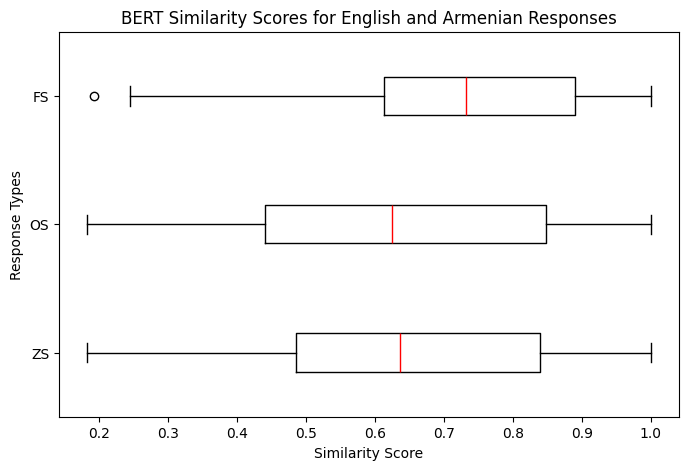

In [33]:
# Boxplot of similarity scores with English Instructions
plt.figure(figsize=(8, 5))
plt.boxplot([df['sim_response_ZS'], df['sim_response_OS'], df['sim_response_FS']],
            labels=['ZS', 'OS', 'FS'], vert=False,
            medianprops=dict(color='red')) 
plt.title('BERT Similarity Scores for English and Armenian Responses')
plt.xlabel('Similarity Score')
plt.ylabel('Response Types')
plt.savefig('bert_score_1.png')
plt.show()

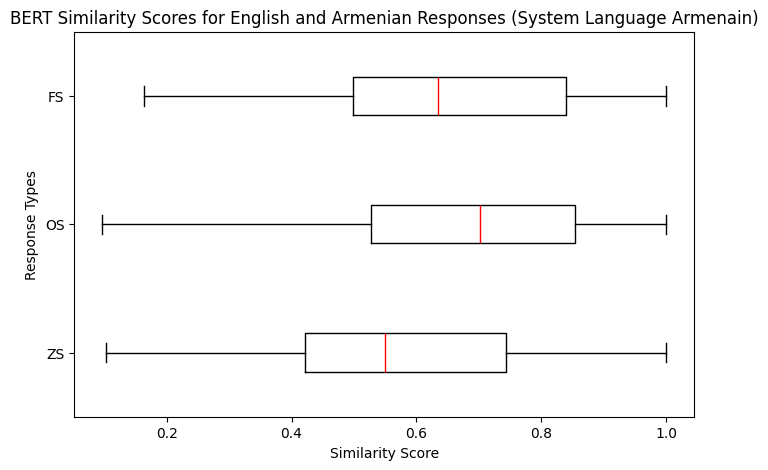

In [34]:
# Boxplot of similarity scores with Armenian Instructions
plt.figure(figsize=(8, 5))
plt.boxplot([df['sim_response_arm_sys_ZS'], df['sim_response_arm_sys_OS'], df['sim_response_arm_sys_FS']],
            labels=['ZS', 'OS', 'FS'], vert=False,
            medianprops=dict(color='red')) 
plt.title('BERT Similarity Scores for English and Armenian Responses (System Language Armenain)')
plt.xlabel('Similarity Score')
plt.ylabel('Response Types')
plt.savefig('bert_score_2.png')
plt.show()

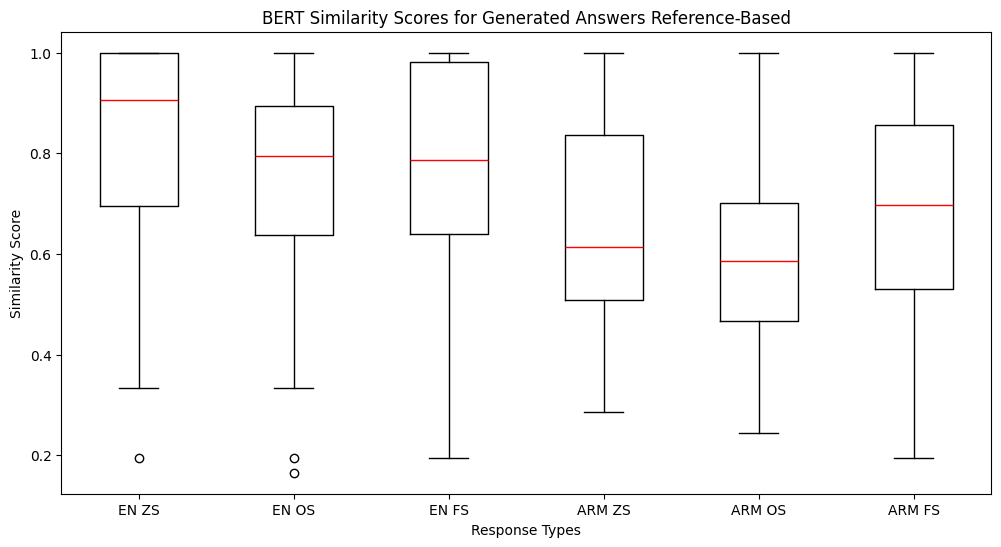

In [35]:
# Boxplot of BERT Similarity Scores for Generated Answers Reference-Based
plt.figure(figsize=(12, 6))
plt.boxplot([df['sim_response_en_reference_ZS'],
    df['sim_response_en_reference_OS'],
    df['sim_response_en_reference_FS'],
    df['sim_response_arm_reference_ZS'],
    df['sim_response_arm_reference_OS'],
    df['sim_response_arm_reference_FS']], 
    labels=['EN ZS', 'EN OS', 'EN FS', 'ARM ZS', 'ARM OS', 'ARM FS'],
    vert=True,
    medianprops=dict(color='red')  
)

plt.title('BERT Similarity Scores for Generated Answers Reference-Based')
plt.xlabel('Response Types')
plt.ylabel('Similarity Score')
plt.savefig('bert_score_3.png')
plt.show()


# Similarity Statistics

In [4]:
# Define the columns for different groups
english_responses = ['sim_response_ZS', 'sim_response_OS', 'sim_response_FS']
armenian_sys_language = ['sim_response_arm_sys_ZS', 'sim_response_arm_sys_OS', 'sim_response_arm_sys_FS']
reference_based = ['sim_response_en_reference_ZS', 'sim_response_en_reference_OS', 'sim_response_en_reference_FS',
                   'sim_response_arm_reference_ZS', 'sim_response_arm_reference_OS', 'sim_response_arm_reference_FS']

# Generate descriptive statistics
english_stats = df[english_responses].describe()
armenian_sys_stats = df[armenian_sys_language].describe()
reference_based_stats = df[reference_based].describe()

# Print the statistics to review them
print("English-Armenian Similarity Statistics:")
print(english_stats)
print("\nEnglish-Armenian Similarity Statistics (Sys lang Arm):")
print(armenian_sys_stats)
print("\nReference-Based Responses Statistics:")
print(reference_based_stats)

English-Armenian Similarity Statistics:
       sim_response_ZS  sim_response_OS  sim_response_FS
count        50.000000        50.000000        50.000000
mean          0.642804         0.614860         0.711794
std           0.246025         0.253477         0.215439
min           0.182537         0.182537         0.192052
25%           0.485079         0.439996         0.613314
50%           0.635740         0.624298         0.731763
75%           0.839834         0.847867         0.889468
max           1.000000         1.000000         1.000000

English-Armenian Similarity Statistics (Sys lang Arm):
       sim_response_arm_sys_ZS  sim_response_arm_sys_OS  \
count                50.000000                50.000000   
mean                  0.585550                 0.664792   
std                   0.212846                 0.229562   
min                   0.103062                 0.097153   
25%                   0.420964                 0.526702   
50%                   0.550154       